In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import time
import numpy as np

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import bnn
from local_logger import Logger

from matplotlib import pyplot as plt

In [3]:
# use GPU for computation if possible
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load a dataset
def get_mnist(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
        transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, download=True,
        transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)

    return train_loader, test_loader

In [5]:
MNIST_INPUT_SHAPE = 28 * 28
MNIST_OUTPUT_SHAPE = 10

# Define a simple 2 layer Network
class Net(nn.Module):
    def __init__(self): #, threshold):
        super(Net, self).__init__()
        self.fc1 = bnn.Linear(MNIST_INPUT_SHAPE, 300)
        self.fc2 = bnn.Linear(300,  100)
        self.fc3 = bnn.Linear(100,  MNIST_OUTPUT_SHAPE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [6]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)

fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

train_loader, test_loader = get_mnist(batch_size=100)
loss_function = bnn.Loss(model, train_size=len(train_loader.dataset), problem='classification').to(DEVICE)

In [7]:
MNIST_INPUT_SHAPE = 28 * 28
epochs = 40

for epoch in range(1, epochs + 1):
    start = time.time()
    model.train()
    train_loss, train_acc = 0, 0
    logger.add_scalar(epoch, 'lr', scheduler.get_last_lr()[0])
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        data = data.view(-1, MNIST_INPUT_SHAPE)
        optimizer.zero_grad()

        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss
        pred = output.data.max(1)[1]
        train_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

    scheduler.step()

    logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
    logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)


    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        data = data.view(-1, MNIST_INPUT_SHAPE)
        output = model(data)
        test_loss += float(loss_function(output, target)) #, kl_weight))
        pred = output.data.max(1)[1]
        test_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)

    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'kl_reg_%s' % i, -c.kl_reg())

    end = time.time()
    logger.add_scalar(epoch, 'time', end - start)

    logger.iter_info()

  epoch       lr    tr_los    tr_acc    te_loss    te_acc    kl_reg_0    kl_reg_1    kl_reg_2    time
-------  -------  --------  --------  ---------  --------  ----------  ----------  ----------  ------
      1  1.0e-03   1.8e+02      91.2    7.5e+01      96.1      -134.4       -23.3        -1.2     7.4
      2  1.0e-03   6.5e+01      96.8    6.0e+01      96.8      -180.7       -33.3        -1.7     6.5
      3  1.0e-03   4.5e+01      97.7    5.5e+01      97.2      -222.4       -41.5        -2.2     6.4
      4  1.0e-03   3.4e+01      98.3    4.6e+01      97.8      -261.1       -49.3        -2.6     6.5
      5  1.0e-03   2.8e+01      98.7    5.0e+01      97.7      -297.9       -56.7        -3.0     6.5
      6  1.0e-03   2.5e+01      98.8    4.4e+01      98.2      -334.0       -64.3        -3.3     6.7
      7  1.0e-03   2.0e+01      99.1    5.9e+01      97.5      -364.3       -70.9        -3.7     6.7
      8  1.0e-03   1.9e+01      99.3    5.6e+01      97.8      -394.0       -77.5 

In [10]:
# plot a grid of `images` with `nrows` rows and `ncols` columns
def plot_images(images, labels, targets, proba, nrows=4, ncols=4):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5*ncols, 1.5*nrows))
    i = 0
    for image, ax in zip(images, axes.flat):
        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)

        # plot image
        ax.imshow(image.view(28, 28).cpu().numpy(),
                  vmin=0.0, vmax=1.0, cmap='gray_r')

        # put the predicted label and the true target
        ax.set_title(f"{labels[i]} vs {targets[i]}, {proba[i]:.2f}")
        i += 1

    plt.tight_layout()
    return fig

/var/folders/jk/_35jq9kx1zlchrr2qjmy3tnr0000gn/T/ipykernel_63107/191033055.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


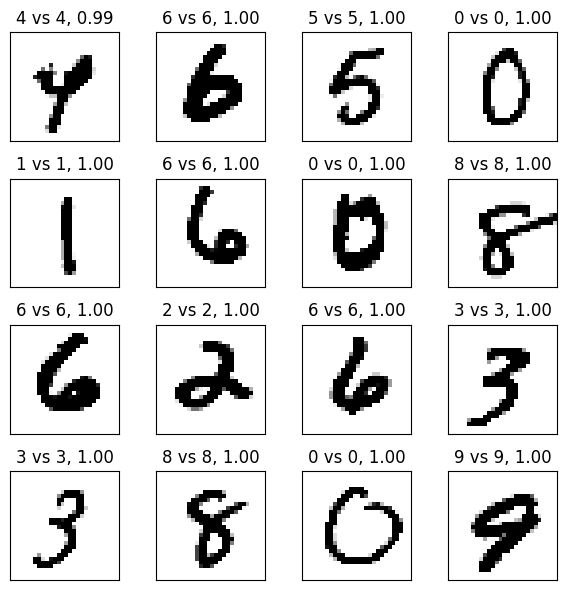

In [14]:
_, test_loader = get_mnist(batch_size=16)
data, target = next(iter(test_loader))

# model.train()
data = data.to(DEVICE)
target = target.to(DEVICE)
data = data.view(-1, MNIST_INPUT_SHAPE)
output = model(data)
proba, pred = torch.exp(output).max(1)
labels = pred.cpu().numpy()

fig = plot_images(data, labels, target, proba)
fig.show()